In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torchsummary import summary
#from model import Net #Importing `Net` from model.py
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [ ]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [ ]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


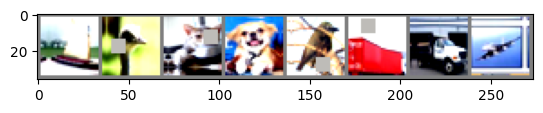

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomBlock, self).__init__()

        self.inner_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.res_block = BasicBlock(out_channels, out_channels)

    def forward(self, x):
        x = self.inner_layer(x)
        r = self.res_block(x)

        out = x + r

        return out


class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()

        self.prep_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.layer_1 = CustomBlock(in_channels=64, out_channels=128)

        self.layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.layer_3 = CustomBlock(in_channels=256, out_channels=512)

        self.max_pool = nn.Sequential(nn.MaxPool2d(kernel_size=4))

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.prep_layer(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
      CustomBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [ ]:
def get_lr(optimizer):
    """"
    for tracking how your learning rate is changing throughout training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.07E-02


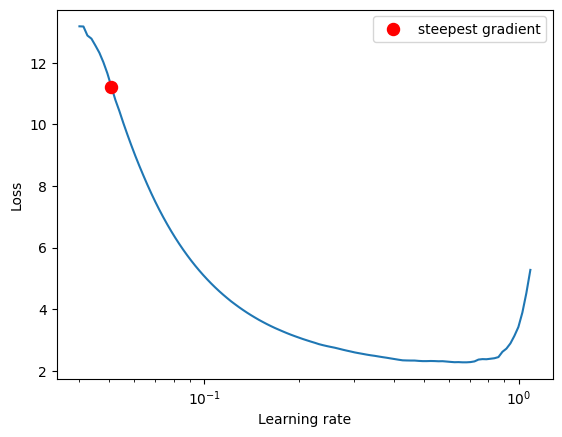

In [ ]:
from torch_lr_finder import LRFinder

model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=4.79E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=1.2523795366287231 LR=0.00998259509202454 Batch_id=97 Accuracy=48.36: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.0025, Accuracy: 5889/10000 (58.89%)

EPOCH: 1


Loss=1.0159035921096802 LR=0.01948619018404908 Batch_id=97 Accuracy=62.69: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0018, Accuracy: 7007/10000 (70.07%)

EPOCH: 2


Loss=0.7897359132766724 LR=0.028989785276073616 Batch_id=97 Accuracy=69.31: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.0015, Accuracy: 7386/10000 (73.86%)

EPOCH: 3


Loss=0.6415098905563354 LR=0.03849338036809816 Batch_id=97 Accuracy=75.61: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set: Average loss: 0.0019, Accuracy: 6932/10000 (69.32%)

EPOCH: 4


Loss=0.6438466906547546 LR=0.04787427754564984 Batch_id=97 Accuracy=76.60: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.0016, Accuracy: 7343/10000 (73.43%)

EPOCH: 5


Loss=0.5573557019233704 LR=0.045353477019334044 Batch_id=97 Accuracy=77.47: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.0015, Accuracy: 7595/10000 (75.95%)

EPOCH: 6


Loss=0.5713669657707214 LR=0.04283267649301826 Batch_id=97 Accuracy=78.61: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set: Average loss: 0.0017, Accuracy: 7259/10000 (72.59%)

EPOCH: 7


Loss=0.5492500066757202 LR=0.040311875966702465 Batch_id=97 Accuracy=79.18: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.0019, Accuracy: 6751/10000 (67.51%)

EPOCH: 8


Loss=0.5930662751197815 LR=0.03779107544038668 Batch_id=97 Accuracy=79.75: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0017, Accuracy: 7355/10000 (73.55%)

EPOCH: 9


Loss=0.4942362308502197 LR=0.03527027491407089 Batch_id=97 Accuracy=79.97: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.0017, Accuracy: 7136/10000 (71.36%)

EPOCH: 10


Loss=0.6011162400245667 LR=0.0327494743877551 Batch_id=97 Accuracy=80.66: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]



Test set: Average loss: 0.0013, Accuracy: 7805/10000 (78.05%)

EPOCH: 11


Loss=0.6102507710456848 LR=0.03022867386143931 Batch_id=97 Accuracy=81.12: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 0.0013, Accuracy: 7815/10000 (78.15%)

EPOCH: 12


Loss=0.5145251154899597 LR=0.02770787333512352 Batch_id=97 Accuracy=81.21: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 0.0013, Accuracy: 7792/10000 (77.92%)

EPOCH: 13


Loss=0.47616586089134216 LR=0.02518707280880773 Batch_id=97 Accuracy=82.26: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 0.0012, Accuracy: 8041/10000 (80.41%)

EPOCH: 14


Loss=0.5546046495437622 LR=0.02266627228249194 Batch_id=97 Accuracy=82.56: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0011, Accuracy: 8208/10000 (82.08%)

EPOCH: 15


Loss=0.5073603391647339 LR=0.020145471756176155 Batch_id=97 Accuracy=83.61: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0011, Accuracy: 8102/10000 (81.02%)

EPOCH: 16


Loss=0.4448339343070984 LR=0.01762467122986036 Batch_id=97 Accuracy=83.82: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.0010, Accuracy: 8213/10000 (82.13%)

EPOCH: 17


Loss=0.3954142928123474 LR=0.015103870703544568 Batch_id=97 Accuracy=84.62: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.0009, Accuracy: 8421/10000 (84.21%)

EPOCH: 18


Loss=0.41152632236480713 LR=0.012583070177228782 Batch_id=97 Accuracy=85.80: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]



Test set: Average loss: 0.0010, Accuracy: 8340/10000 (83.40%)

EPOCH: 19


Loss=0.3525547981262207 LR=0.010062269650912989 Batch_id=97 Accuracy=86.78: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.0008, Accuracy: 8629/10000 (86.29%)

EPOCH: 20


Loss=0.3230222463607788 LR=0.007541469124597203 Batch_id=97 Accuracy=88.13: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.0008, Accuracy: 8727/10000 (87.27%)

EPOCH: 21


Loss=0.3411402404308319 LR=0.005020668598281416 Batch_id=97 Accuracy=89.54: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.0007, Accuracy: 8860/10000 (88.60%)

EPOCH: 22


Loss=0.1640564650297165 LR=0.00249986807196563 Batch_id=97 Accuracy=91.61: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]



Test set: Average loss: 0.0006, Accuracy: 9059/10000 (90.59%)

EPOCH: 23


Loss=0.18173860013484955 LR=-2.0932454350162943e-05 Batch_id=97 Accuracy=93.46: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.0005, Accuracy: 9125/10000 (91.25%)

